In [133]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pyAgrum as gum
import pyAgrum.lib.explain as explain
from sklearn.dummy import DummyClassifier
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bnvsbn

In [134]:
df = pd.read_csv('https://raw.githubusercontent.com/ImagineDogs/TranstornosMentais/main/dados/df_cid10.csv')
diagnosticos = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo',
                        'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']].loc[~df['cid10_faixa'].isnull()]
diagnosticos = diagnosticos.fillna('Sem')

In [135]:
df_train, df_test = train_test_split(diagnosticos, train_size = 0.8, random_state=42)

In [136]:
template = gum.BayesNet('Plus')
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes']
for i in labels:
  if diagnosticos[i].dtypes == 'int64':
    template.add(gum.IntegerVariable(i, "", diagnosticos[i].unique().tolist()))
  else:
    template.add(gum.LabelizedVariable(i, "", diagnosticos[i].unique().tolist()))
template

(pyAgrum.BayesNet<double>@000001B75C9A1510) BN{nodes: 14, arcs: 0, domainSize: 10^9.85975, dim: 79, mem: 744o}

Naive Bayes sem dados de treino

In [137]:
labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')

alta = ''
for j in diagnosticos['cid10_faixa_alta'].unique():
  alta += '|' + str(j)
alta = 'cid10_faixa_alta{' + alta[1:] + '}'

conections = ''
for i in labels2:
  label = ''
  for j in diagnosticos[i].unique():
    label += '|' + str(j)
  label = i + '{' + label[1:] + '}' 
  
  conections += f'{label}<-{alta};'
bn=gum.fastBN(conections)
gnb.showBN(bn)

In [138]:
conections

'cid10_faixa{F10-F19|F60-F69|F30-F39|F70-F79|F20-F29|F01-F09|F40-F49|F90-F98|F99-F99|F50-F59|F80-F89}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};cid10_seg_faixa{Sem|F60-F69|F10-F19|F30-F39|F20-F29|F01-F09|F70-F79|F40-F49|F50-F59|F90-F98|F80-F89|F99-F99}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};sexo{F|M|T}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};faixa_etaria{40-49|30-39|60-69|15-19|20-29|50-59|Sem|10-14|70-79|0-9|>80}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};etnia{BRANCO|PARDO|NEGRO|NAO INFORMADO|AMARELO}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};qtd_internacoes{8|4|2|3|5|12|13|1|6|15|7|10|18|14|9|20|16|17|11}<-cid10_faixa_alta{F10-F19|F60-F69|F

Naive Bayes com dados de treino

In [139]:
learner = gum.BNLearner(df_train, bn)
bn1 = learner.learnParameters(bn.dag())
bn1

(pyAgrum.BayesNet<double>@000001B75C9A03A0) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 827, mem: 7Ko 704o}

Rede encontrada a partir dos dados de treino

In [140]:
learner = gum.BNLearner(df_train, template)
bn2 = learner.learnBN()
bn2

(pyAgrum.BayesNet<double>@000001B75C329540) BN{nodes: 14, arcs: 15, domainSize: 10^9.85975, dim: 512, mem: 4Ko 704o}

Rede encontrada a partir dos dados de treino com conexões obrigatórias

In [141]:
learner = gum.BNLearner(df_train, template)
learner.addMandatoryArc('cid10_seg_faixa', 'cid10_faixa_alta')
learner.addMandatoryArc('sexo', 'cid10_faixa_alta')
learner.addMandatoryArc('cid10_faixa', 'cid10_faixa_alta')

bn3 = learner.learnBN()
bn3

(pyAgrum.BayesNet<double>@000001B75C9A20B0) BN{nodes: 14, arcs: 18, domainSize: 10^9.85975, dim: 4666, mem: 40Ko 152o}

Classificador

In [142]:
import pyAgrum.skbn as skbn

In [143]:
y_train = df_train['cid10_faixa_alta']
X_train = df_train.drop(['cid10_faixa_alta'], axis=1)
y_test = df_test['cid10_faixa_alta']
X_test = df_test.drop(['cid10_faixa_alta'], axis=1)

In [144]:
scoreAll = pd.DataFrame()

Naive Bayes sem treinamento

In [145]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes sem treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F10-F19', 'F30-F39', 'F10-F19', 'F90-F98', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F60-F69', 'F30-F39', 'F90-F98', 'F30-F39', 'F99-F99', 'F60-F69', 'F90-F98', 'F10-F19', 'F20-F29', 'F30-F39', 'F30-F39', 'F60-F69', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F99-F99', 'F10-F19', 'F99-F99', 'F90-F98', 'F10-F19', 'F60-F69', 'F10-F19', 'F30-F39', 'F20-F29', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F40-F49', 'F70-F79', 'F10-F19', 'F10-F19', 'F90-F98', 'F70-F79', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F99-F99', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F60-F69', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F99-F99', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F99-F99', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39

Naive Bayes com treinamento

In [146]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn1,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes com treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F90-F98', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'Sem', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F30-F39', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', '

Rede econtrada pelo treinamento

Binary classifier : False


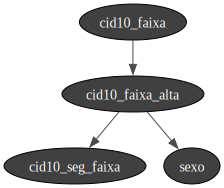

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F30-F39', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [147]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn2,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede econtrada pelo treinamento'] = pd.Series(scoreCSV1)

Rede encontrada pelo treinamento, com conexões obrigatórias

Binary classifier : False


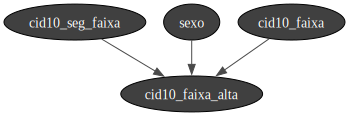

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [148]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn3,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede encontrada pelo treinamento, com conexões obrigatórias'] = pd.Series(scoreCSV1)

In [149]:
scoreAll

,Naive Bayes sem treinamento,Naive Bayes com treinamento,Rede econtrada pelo treinamento,"Rede encontrada pelo treinamento, com conexões obrigatórias"
0,0.216545,0.705596,0.737835,0.740876


bayesian_data/X_test.csv:   0%|          |

bayesian_data/X_test.csv: 100%|██████████|


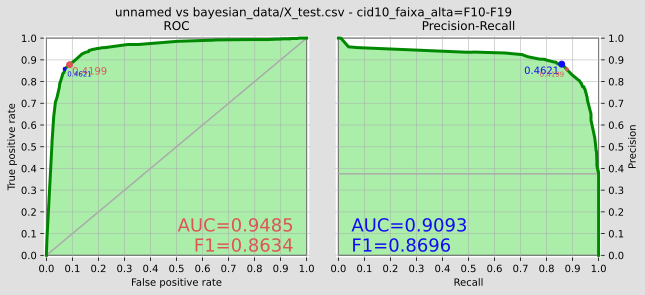

(0.9485290984583189, 0.41994892945, 0.9093314353009152, 0.4621416787)

In [150]:
from pyAgrum.lib.bn2roc import showROC_PR
showROC_PR(bn3, "bayesian_data/X_test.csv", 'cid10_faixa_alta', "F10-F19", show_progress=True, show_fig=True)

In [151]:
bn3

(pyAgrum.BayesNet<double>@000001B75C9A20B0) BN{nodes: 14, arcs: 18, domainSize: 10^9.85975, dim: 4666, mem: 40Ko 152o}

In [152]:
gnb.flow.row(gnb.getInference(bn3, evs = {'sexo': 'F'}), gnb.getInference(bn3))

In [153]:
# bn3.erase('has')

In [154]:
bn3.parents('cid10_faixa_alta')

{0, 2, 3}

In [230]:
def search(graph, top, bottom):
    topfound = []
    pathfound = []

    parent = graph.parents(bottom)
    print(parent, bottom, top)
    if parent == set() and bottom in top:
        print('a')
        return [], [bottom]

    elif parent == set() and bottom not in top:
        print('b')
        return [], None

    elif parent != set():
        print('c')
        # if bottom == 5:
        #     print(parent)
        if bottom in top:
            topfound = [bottom]
        # if type = (parent)
        i = 0
        for node in parent:
            print('iteracao: ', i, ', nó: ', node)
            print('')
            i += 1h
            auxpath, auxtop = search(graph, top, node)
            print(auxpath)
            pathfound = set(auxpath) | set(pathfound) | set([node])
            topfound = set(auxtop) | set(topfound)
        print(pathfound)
        return pathfound, topfound 
        print('d')
    return pathfound, topfound


In [174]:
def subgraph(graph, top=[], bottom = None):
    if bottom = None:
        return 'Colocar último'

    
    nos_validos, topos = search(graph, top, bottom)
    nos_validos.extend(bottom)




SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1318945964.py, line 2)

In [236]:
caminho, pais = search(bn3, [5], 11)

{8, 13} 11 [5]
c
iteracao:  0 , nó:  8

{7} 8 [5]
c
iteracao:  0 , nó:  7

{3} 7 [5]
c
iteracao:  0 , nó:  3

{6} 3 [5]
c
iteracao:  0 , nó:  6

{5} 6 [5]
c
iteracao:  0 , nó:  5

set() 5 [5]
a
[]
{5}
{5}
{5, 6}
{5, 6}
{3, 5, 6}
{3, 5, 6}
{3, 5, 6, 7}
{3, 5, 6, 7}
iteracao:  1 , nó:  13

{8, 9} 13 [5]
c
iteracao:  0 , nó:  8

{7} 8 [5]
c
iteracao:  0 , nó:  7

{3} 7 [5]
c
iteracao:  0 , nó:  3

{6} 3 [5]
c
iteracao:  0 , nó:  6

{5} 6 [5]
c
iteracao:  0 , nó:  5

set() 5 [5]
a
[]
{5}
{5}
{5, 6}
{5, 6}
{3, 5, 6}
{3, 5, 6}
{3, 5, 6, 7}
{3, 5, 6, 7}
iteracao:  1 , nó:  9

{8, 7} 9 [5]
c
iteracao:  0 , nó:  8

{7} 8 [5]
c
iteracao:  0 , nó:  7

{3} 7 [5]
c
iteracao:  0 , nó:  3

{6} 3 [5]
c
iteracao:  0 , nó:  6

{5} 6 [5]
c
iteracao:  0 , nó:  5

set() 5 [5]
a
[]
{5}
{5}
{5, 6}
{5, 6}
{3, 5, 6}
{3, 5, 6}
{3, 5, 6, 7}
{3, 5, 6, 7}
iteracao:  1 , nó:  7

{3} 7 [5]
c
iteracao:  0 , nó:  3

{6} 3 [5]
c
iteracao:  0 , nó:  6

{5} 6 [5]
c
iteracao:  0 , nó:  5

set() 5 [5]
a
[]
{5}
{5}
{5, 6}
{

In [187]:
set(set(set([1, 2]) | set([2, 3])))

{1, 2, 3}

In [191]:
# bn3.idFromName('has')
bn3.names()

# bn3.variableFromName('has')

{'avc',
 'cid10_faixa',
 'cid10_faixa_alta',
 'cid10_seg_faixa',
 'convulsao',
 'diabetes',
 'etnia',
 'faixa_etaria',
 'gravidez',
 'has',
 'prob_respiratorios',
 'qtd_internacoes',
 'sexo',
 'traumatismo'}

In [245]:
bn3.variable(3).name()

'sexo'

In [192]:
bn3.nodes()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

In [246]:
conversor = {}
for i in zip(bn3.nodes(), bn3.names()):
    node = bn3.variable(i)
    name = node.name()
    print(name)

TypeError: in method 'BayesNet_variable', argument 2 of type 'std::string const &'
Additional information:
Wrong number or type of arguments for overloaded function 'BayesNet_variable'.
  Possible C/C++ prototypes are:
    gum::BayesNet< double >::variable(gum::NodeId) const
    gum::BayesNet< double >::variable(std::string const &) const


In [247]:
for i in caminho:
    node = bn3.variable(i)
    name = node.name()
    print(name)

sexo
etnia
qtd_internacoes
traumatismo
prob_respiratorios
avc
diabetes


In [190]:
bn3

(pyAgrum.BayesNet<double>@000001B75C9A20B0) BN{nodes: 14, arcs: 18, domainSize: 10^9.85975, dim: 4666, mem: 40Ko 152o}